In [1]:
%load_ext autoreload
%autoreload 2

In [23]:
"""
This is the data processing script for POP909: A Pop song Dataset for Music Arrangement Generation.

It will allow you to quickly process the POP909 Files (Midi) into the Google Magenta's music representation 
as in [Music Transformer](https://magenta.tensorflow.org/music-transformer) and
[Performance RNN](https://magenta.tensorflow.org/performance-rnn).

Modified from: https://github.com/music-x-lab/POP909-Dataset/blob/master/data_process/data_process.ipynb
"""

import csv
import itertools
import pickle
import random
import os
import sys
from dataclasses import dataclass

import numpy as np
import pretty_midi
import pypianoroll
import torch
from matplotlib import pyplot as plt
from pprint import pprint
from tqdm import tqdm
from IPython.display import clear_output
from ipywidgets import interact, IntSlider
from livelossplot import PlotLosses
from livelossplot.outputs import MatplotlibPlot

from processor import MidiEventProcessor

In [2]:
@dataclass
class Chord:
    name: str
    start_time: float
    end_time: float


@dataclass
class Event:
    token: int
    chord: Chord


@dataclass
class Segment:
    chord_token: int
    event_tokens: list


@dataclass
class Chunk:
    chords: list
    events: list


class ChordVocab:
    def __init__(self, chords):
        self.chords = chords.copy()
        self.chord_to_token = {chord: i for i, chord in enumerate(chords)}

In [3]:
def get_unique_chords(data_root):
    chords = set()
    for song_idx in sorted(os.listdir(data_root)):
        song_dir = os.path.join(data_root, song_idx)
        if not os.path.isdir(song_dir):
            continue
        chord_path = os.path.join(song_dir, "chord_midi.txt")
        with open(chord_path, newline="") as f:
            reader = csv.reader(f, delimiter="\t")
            chord_data = list(reader)
        for _, _, chord in chord_data:
            chords.add(chord)
    return chords


def make_chord_vocab(data_root, out_path):
    unique_chords = list(get_unique_chords(data_root))
    unique_chords.sort()
    unique_chords.remove("N")
    unique_chords.insert(0, "N")
    with open(out_path, "w") as f:
        for chord in unique_chords:
            f.write(f"{chord}\n")


def load_chord_vocab(vocab_path):
    with open(vocab_path, "r") as f:
        chords = f.read().splitlines()
    return ChordVocab(chords)

In [4]:
make_chord_vocab("./original", "./chord_vocab.txt")

In [7]:
chord_vocab = load_chord_vocab("./chord_vocab.txt")

In [15]:
def preprocess_song(midi_path, chord_path, chord_vocab):
    midi_data = pretty_midi.PrettyMIDI(midi_path)
    
    assert midi_data.instruments[0].name == "MELODY"
    assert midi_data.instruments[1].name == "BRIDGE"
    assert midi_data.instruments[2].name == "PIANO"
    
    melody = midi_data.instruments[0].notes
    bridge = midi_data.instruments[1].notes
    piano = midi_data.instruments[2].notes

    notes = melody + bridge + piano
    notes.sort(key=lambda note: note.start)
    
    with open(chord_path, newline="") as f:
        reader = csv.reader(f, delimiter="\t")
        chord_data = list(reader)

    chords = [
        Chord(chord, float(start_time), float(end_time))
        for start_time, end_time, chord in chord_data
    ]
    mep = MidiEventProcessor()
    events = mep.encode(notes, chords)

    segments = []
    for chord in chords:
        event_tokens = [e.token for e in events if e.chord is chord]
        chord_token = chord_vocab.chord_to_token[chord.name]
        segment = Segment(chord_token, event_tokens)
        segments.append(segment)
    return segments


def preprocess_pop909(data_root, chord_vocab_path, out_dir):
    chord_vocab = load_chord_vocab(chord_vocab_path)
    os.makedirs(out_dir, exist_ok=True)
    for song_idx in sorted(os.listdir(data_root)):
        song_dir = os.path.join(data_root, song_idx)
        if not os.path.isdir(song_dir):
            continue
        print(f"Processing song {song_idx}")
        midi_path = os.path.join(song_dir, f"{song_idx}.mid")
        chord_path = os.path.join(song_dir, "chord_midi.txt")
        segments = preprocess_song(midi_path, chord_path, chord_vocab)
        out_path = os.path.join(out_dir, f"{song_idx}.pkl")
        with open(out_path, "wb") as f:
            pickle.dump(segments, f)

In [ ]:
preprocess_pop909(
    data_root="./original",
    chord_vocab_path="./chord_vocab.txt",
    out_dir="./processed",
)

In [62]:
def group(iterable, n, fillvalue=None):
    """
    Example:
    >>> group("ABCDEFG", 3, "x")
    ABC DEF Gxx
    
    Source: https://docs.python.org/3/library/itertools.html.
    """
    args = [iter(iterable)] * n
    return itertools.zip_longest(*args, fillvalue=fillvalue)


def get_chunks(path, n=4, eos_token=356):
    """
    Create a list of chunks, i.e. {chord_tokens, event_tokens} pairs,
    from a file containing the segments of a song.
    
    Also append an end-of-sequence token to every sequence of event
    tokens.
    
    Args:
        path: The path to the source file.
        n: The number of segments per data point.
    """
    segments = pickle.load(open(path, "rb"))
    segments = filter(lambda s: len(s.event_tokens) > 0, segments)
    chunks = []
    for segment_group in group(segments, n):
        if None in segment_group:
            continue
        chord_tokens = [s.chord_token for s in segment_group]
        event_tokens = []
        for s in segment_group:
            event_tokens.extend(s.event_tokens)
        event_tokens.append(eos_token)
        chunk = Chunk(chords=chord_tokens, events=event_tokens)
        chunks.append(chunk)
    return chunks


def get_all_chunks(data_root, n=4):
    """
    Get the chunks from all songs and combine them.
    """
    all_chunks = []
    for file_name in sorted(os.listdir(data_root)):
        if not file_name.endswith(".pkl"):
            continue
        path = os.path.join(data_root, file_name)
        chunks = get_chunks(path, n)
        all_chunks.extend(chunks)
    return all_chunks

In [63]:
chunks = get_all_chunks("./processed")
with open("./pop909.pkl", "wb") as f:
    pickle.dump(chunks, f)

In [64]:
class MusicDataset(torch.utils.data.Dataset):
    """
    A dataset of chunks from songs. Each chunk consists of a sequence of
    4 chords along with a sequence of notes played with those chords.
    
    The chords and the notes are both tokenized already, and converted to
    tensors when __getitem__ is called.
    """

    def __init__(self, data_path):
        super().__init__()
        self.data_path = data_path

        data = pickle.load(open(data_path, "rb"))
        self._chords = [torch.LongTensor(d.chords) for d in data]
        self._events = [torch.LongTensor(d.events) for d in data]
        
    def __len__(self):
        return len(self._chords)
    
    def __getitem__(self, idx):
        return (
            self._chords[idx],
            self._events[idx],
        )

In [65]:
dataset = MusicDataset("./pop909.pkl")

In [66]:
len(dataset)

30176

In [76]:
seq_lens = [len(d[1]) for d in dataset]
print(max(seq_lens))

1028


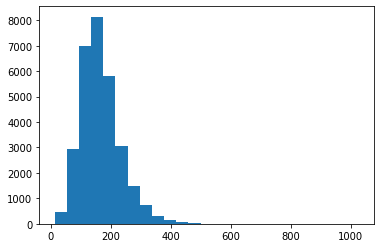

In [75]:
plt.hist(seq_lens, bins=25)
plt.show()

The following code is largely based on https://colab.research.google.com/github/salu133445/ismir2019tutorial/blob/main/musegan.ipynb.

In [5]:
m = pypianoroll.load("../data/001/001.npz")
m.trim(end=12 * 96)

Multitrack(name='001', resolution=24, tempo=array(shape=(1152,), dtype=float64), downbeat=array(shape=(1152,), dtype=bool), tracks=[StandardTrack(name='MAIN', program=0, is_drum=False, pianoroll=array(shape=(1152, 128), dtype=uint8))])

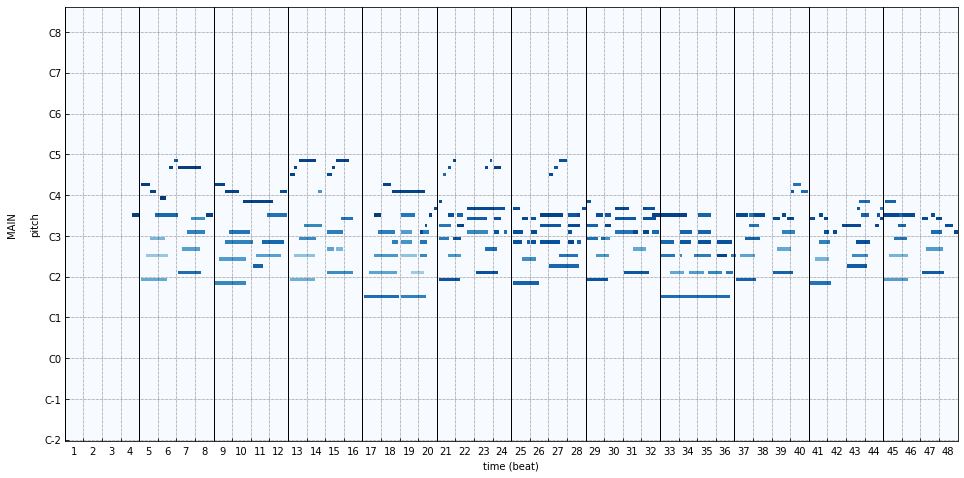

In [6]:
axs = m.plot()
plt.gcf().set_size_inches((16, 8))
for ax in axs:
    for x in range(96, 12 * 96, 96):     
        ax.axvline(x - 0.5, color='k', linestyle='-', linewidth=1)
plt.show()

In [7]:
ROOT_DIR = "../data"

midi_paths = []
for song_idx in sorted(os.listdir(ROOT_DIR)):
    song_dir = os.path.join(ROOT_DIR, song_idx)
    if not os.path.isdir(song_dir):
        continue
    midi_path = os.path.join(song_dir, f"{song_idx}.npz")
    midi_paths.append(midi_path)

In [8]:
CUDA = torch.cuda.is_available()

BEAT_RESOLUTION = 4
MEASURE_RESOLUTION = BEAT_RESOLUTION * 4
LOWEST_PITCH = 0  # TODO
N_TRACKS = 1
N_PITCHES = 128  # TODO
N_SAMPLES_PER_SONG = 32  # number of samples to extract from each song in the datset
N_MEASURES = 1  # number of measures per sample

# Training
BATCH_SIZE = 16
LATENT_DIM = 128
N_STEPS = 20000

# Sampling
SAMPLE_INTERVAL = 100  # interval to run the sampler (in step)
N_SAMPLES = 4

In [9]:
data = []
# Iterate over all the songs in the ID list
for midi_path in tqdm(midi_paths):
    # Load the multitrack as a pypianoroll.Multitrack instance
    multitrack = pypianoroll.load(midi_path)
    # Binarize the pianorolls
    multitrack.binarize()
    # Downsample the pianorolls (shape: n_timesteps x n_pitches)
    multitrack.set_resolution(BEAT_RESOLUTION)
    # Stack the pianoroll (shape: n_tracks x n_timesteps x n_pitches)
    pianoroll = (multitrack.stack() > 0)
    # Get the target pitch range only
    pianoroll = pianoroll[:, :, LOWEST_PITCH:LOWEST_PITCH + N_PITCHES]
    # Calculate the total measures
    n_total_measures = multitrack.get_max_length() // MEASURE_RESOLUTION
    candidate = n_total_measures - N_MEASURES
    target_n_samples = min(n_total_measures // N_MEASURES - 1, N_SAMPLES_PER_SONG)
    # Randomly select a number of phrases from the multitrack pianoroll
    for idx in np.random.choice(candidate, target_n_samples, False):
        start = idx * MEASURE_RESOLUTION
        end = (idx + N_MEASURES) * MEASURE_RESOLUTION
        # Skip the samples where some track(s) has too few notes
        if (pianoroll.sum(axis=(1, 2)) < 10).any():
            continue
        data.append(pianoroll[:, start:end])

In [10]:
# Stack all the collected pianoroll segments into one big array
random.shuffle(data)
data = np.stack(data)
print(f"Successfully collect {len(data)} samples from {len(midi_paths)} songs")
print(f"Data shape : {data.shape}")

Successfully collect 29039 samples from 909 songs
Data shape : (29039, 1, 16, 128)


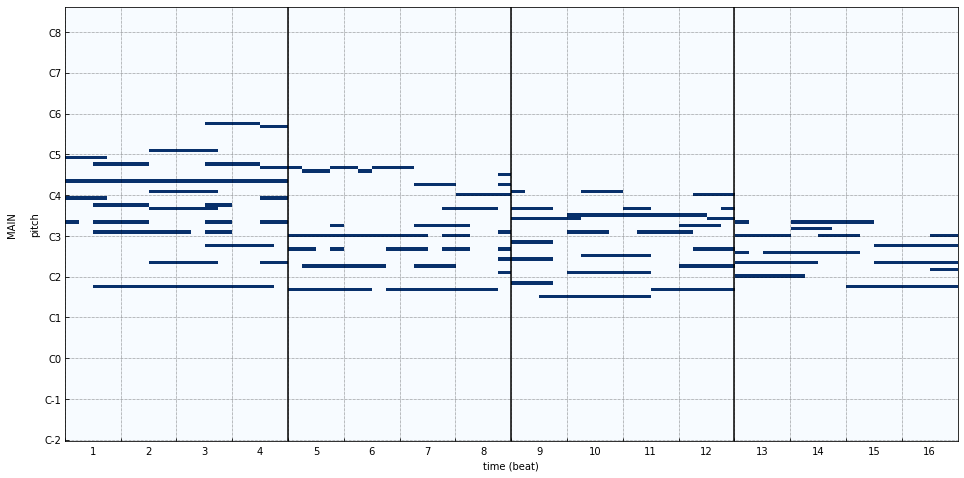

In [11]:
TEMPO = 100

# Visualize some of the training samples
tempo_array = np.full((4 * 4 * MEASURE_RESOLUTION, 1), TEMPO)
tracks = []
pianoroll = np.pad(np.concatenate(data[:4], 1)[0], ((0, 0), (LOWEST_PITCH, 128 - LOWEST_PITCH - N_PITCHES)))
tracks.append(pypianoroll.Track(name="MAIN", program=0, is_drum=False, pianoroll=pianoroll))
multitrack = pypianoroll.Multitrack(tracks=tracks, tempo=tempo_array, resolution=BEAT_RESOLUTION)
axs = multitrack.plot()
plt.gcf().set_size_inches((16, 8))
for ax in axs:
    for x in range(MEASURE_RESOLUTION, 4 * MEASURE_RESOLUTION, MEASURE_RESOLUTION):
        if x % MEASURE_RESOLUTION == 0:
            ax.axvline(x - 0.5, color='k')
        else:
            ax.axvline(x - 0.5, color='k', linestyle='-', linewidth=1)
plt.show()

## Dataset

In [12]:
data = torch.as_tensor(data, dtype=torch.float32)
dataset = torch.utils.data.TensorDataset(data)
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    drop_last=True,
    shuffle=True,
)

## Model definitions

In [13]:
class GeneratorBlock(torch.nn.Module):
    def __init__(self, in_dim, out_dim, kernel, stride):
        super().__init__()
        self.transconv = torch.nn.ConvTranspose3d(in_dim, out_dim, kernel, stride)
        self.batchnorm = torch.nn.BatchNorm3d(out_dim)
    
    def forward(self, x):
        x = self.transconv(x)
        x = self.batchnorm(x)
        return torch.nn.functional.relu(x)

In [14]:
class Generator(torch.nn.Module):
    """A convolutional neural network (CNN) based generator. The generator takes
    as input a latent vector and outputs a fake sample."""
    def __init__(self):
        super().__init__()
        self.transconv0 = GeneratorBlock(LATENT_DIM, 256, (4, 1, 1), (4, 1, 1))
        self.transconv1 = GeneratorBlock(256, 128, (1, 4, 1), (1, 4, 1))
        self.transconv2 = GeneratorBlock(128, 64, (1, 1, 4), (1, 1, 4))
        self.transconv3 = GeneratorBlock(64, 32, (1, 1, 5), (1, 1, 1))
        self.transconv4 = GeneratorBlock(32, 16, (1, 1, 1), (1, 1, 1))

    def forward(self, x):
        x = x.view(-1, LATENT_DIM, 1, 1, 1)
        x = self.transconv0(x)
        x = self.transconv1(x)
        x = self.transconv2(x)
        x = self.transconv3(x)
        x = self.transconv4(x)
        x = x.view(-1, 1, N_MEASURES * MEASURE_RESOLUTION, N_PITCHES)
        return x

In [15]:
class LayerNorm(torch.nn.Module):
    """An implementation of Layer normalization that does not require size
    information. Copied from https://github.com/pytorch/pytorch/issues/1959."""
    def __init__(self, n_features, eps=1e-5, affine=True):
        super().__init__()
        self.n_features = n_features
        self.affine = affine
        self.eps = eps
        if self.affine:
            self.gamma = torch.nn.Parameter(torch.Tensor(n_features).uniform_())
            self.beta = torch.nn.Parameter(torch.zeros(n_features))

    def forward(self, x):
        shape = [-1] + [1] * (x.dim() - 1)
        mean = x.view(x.size(0), -1).mean(1).view(*shape)
        std = x.view(x.size(0), -1).std(1).view(*shape)
        y = (x - mean) / (std + self.eps)
        if self.affine:
            shape = [1, -1] + [1] * (x.dim() - 2)
            y = self.gamma.view(*shape) * y + self.beta.view(*shape)
        return y

In [16]:
class DiscriminatorBlock(torch.nn.Module):
    def __init__(self, in_dim, out_dim, kernel, stride):
        super().__init__()
        self.transconv = torch.nn.Conv3d(in_dim, out_dim, kernel, stride)
        self.layernorm = LayerNorm(out_dim)
    
    def forward(self, x):
        x = self.transconv(x)
        x = self.layernorm(x)
        return torch.nn.functional.leaky_relu(x)

In [17]:
class Discriminator(torch.nn.Module):
    """A convolutional neural network (CNN) based discriminator. The
    discriminator takes as input either a real sample (in the training data) or
    a fake sample (generated by the generator) and outputs a scalar indicating
    its authentity.
    """
    def __init__(self):
        super().__init__()
        self.conv0 = DiscriminatorBlock(1, 16, (1, 1, 12), (1, 1, 12))
        self.conv1 = DiscriminatorBlock(16, 16, (1, 4, 1), (1, 4, 1))
        self.conv2 = DiscriminatorBlock(16, 64, (1, 1, 3), (1, 1, 1))
        self.conv3 = DiscriminatorBlock(64, 64, (1, 1, 4), (1, 1, 4))
        self.conv4 = DiscriminatorBlock(64, 128, (1, 4, 1), (1, 4, 1))
        self.conv5 = DiscriminatorBlock(128, 128, (1, 1, 1), (1, 1, 1)) # originally (2, 1, 1), (1, 1, 1)
        self.conv6 = DiscriminatorBlock(128, 256, (1, 1, 1), (3, 1, 2)) # originally (3, 1, 1), (3, 1, 1)
        self.dense = torch.nn.Linear(256, 1)

    def forward(self, x):
        x = x.view(-1, N_TRACKS, N_MEASURES, MEASURE_RESOLUTION, N_PITCHES)
        x = self.conv0(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = x.view(-1, 256)
        x = self.dense(x)
        return x

## Training functions

In [18]:
def compute_gradient_penalty(discriminator, real_samples, fake_samples):
    """Compute the gradient penalty for regularization. Intuitively, the
    gradient penalty help stablize the magnitude of the gradients that the
    discriminator provides to the generator, and thus help stablize the training
    of the generator."""
    # Get random interpolations between real and fake samples
    alpha = torch.rand(real_samples.size(0), 1, 1, 1)
    if torch.cuda.is_available():
        alpha = alpha.cuda()
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples))
    interpolates = interpolates.requires_grad_(True)
    # Get the discriminator output for the interpolations
    d_interpolates = discriminator(interpolates)
    # Get gradients w.r.t. the interpolations
    fake = torch.ones(real_samples.size(0), 1)
    if torch.cuda.is_available():
        fake = fake.cuda()
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    # Compute gradient penalty
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

In [26]:
def train_one_step(d_optimizer, g_optimizer, real_samples):
    """Train the networks for one step."""
    # Sample from the lantent distribution
    latent = torch.randn(BATCH_SIZE, LATENT_DIM)

    # Transfer data to GPU
    if torch.cuda.is_available():
        real_samples = real_samples.cuda()
        latent = latent.cuda()
    
    # === Train the discriminator ===
    # Reset cached gradients to zero
    d_optimizer.zero_grad()
    # Get discriminator outputs for the real samples
    prediction_real = discriminator(real_samples)
    # Compute the loss function
    # d_loss_real = torch.mean(torch.nn.functional.relu(1. - prediction_real))
    d_loss_real = -torch.mean(prediction_real)
    # Backpropagate the gradients
    d_loss_real.backward()
    
    # Generate fake samples with the generator
    fake_samples = generator(latent)
    # Get discriminator outputs for the fake samples
    prediction_fake_d = discriminator(fake_samples.detach())
    # Compute the loss function
    # d_loss_fake = torch.mean(torch.nn.functional.relu(1. + prediction_fake_d))
    d_loss_fake = torch.mean(prediction_fake_d)
    # Backpropagate the gradients
    d_loss_fake.backward()

    # Compute gradient penalty
    gradient_penalty = 10.0 * compute_gradient_penalty(
        discriminator, real_samples.data, fake_samples.data)
    # Backpropagate the gradients
    gradient_penalty.backward()

    # Update the weights
    d_optimizer.step()
    
    # === Train the generator ===
    # Reset cached gradients to zero
    g_optimizer.zero_grad()
    # Get discriminator outputs for the fake samples
    prediction_fake_g = discriminator(fake_samples)
    # Compute the loss function
    g_loss = -torch.mean(prediction_fake_g)
    # Backpropagate the gradients
    g_loss.backward()
    # Update the weights
    g_optimizer.step()

    return d_loss_real + d_loss_fake, g_loss

## Training setup

In [27]:
# Create data loader
# data_loader = get_data_loader()

# Create neural networks
discriminator = Discriminator()
generator = Generator()
print("Number of parameters in G: {}".format(
    sum(p.numel() for p in generator.parameters() if p.requires_grad)))
print("Number of parameters in D: {}".format(
    sum(p.numel() for p in discriminator.parameters() if p.requires_grad)))

# Create optimizers
d_optimizer = torch.optim.Adam(
    discriminator.parameters(), lr=0.001,  betas=(0.5, 0.9))
g_optimizer = torch.optim.Adam(
    generator.parameters(), lr=0.001, betas=(0.5, 0.9))

# Prepare the inputs for the sampler, which wil run during the training
sample_latent = torch.randn(N_SAMPLES, LATENT_DIM)

# Transfer the neural nets and samples to GPU
if torch.cuda.is_available():
    discriminator = discriminator.cuda()
    generator = generator.cuda()
    sample_latent = sample_latent.cuda()

# Create an empty dictionary to sotre history samples
history_samples = {}

# Create a LiveLoss logger instance for monitoring
liveloss = PlotLosses(outputs=[MatplotlibPlot(cell_size=(6,2))])

# Initialize step
step = 0

Number of parameters in G: 307152
Number of parameters in D: 104865


In [28]:
sample_latent = torch.randn(1, LATENT_DIM)
print(generator(sample_latent).shape)

torch.Size([1, 1, 16, 128])


## Training

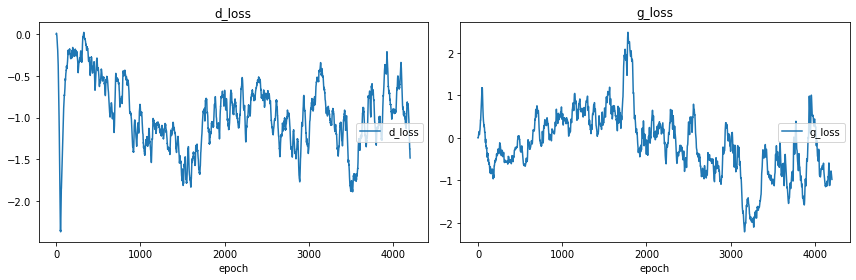

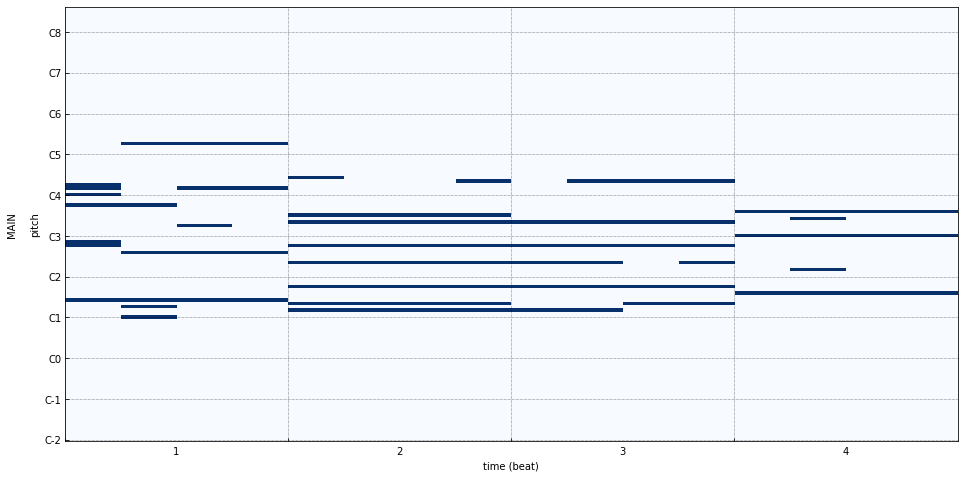

Step 4200 	 D-loss: -1.731927 	 G-loss: -1.389770


KeyboardInterrupt: 

In [35]:
# Create a progress bar instance for monitoring
# progress_bar = tqdm(total=N_STEPS, initial=step, ncols=80, mininterval=1)
LOG_EVERY_N = 100

# Start iterations
while step < N_STEPS + 1:
    # Iterate over the dataset
    for real_samples in data_loader:
        # Train the neural networks
        generator.train()
        d_loss, g_loss = train_one_step(d_optimizer, g_optimizer, real_samples[0])

        # Record smoothened loss values to LiveLoss logger
        if step > 0:
            running_d_loss = 0.05 * d_loss + 0.95 * running_d_loss
            running_g_loss = 0.05 * g_loss + 0.95 * running_g_loss
        else:
            running_d_loss, running_g_loss = 0.0, 0.0
        # liveloss.update({'negative_critic_loss': -running_d_loss})
        liveloss.update({'d_loss': running_d_loss, 'g_loss': running_g_loss})
        
        # Update losses to progress bar
        # progress_bar.set_description_str(
        #     "(d_loss={: 8.6f}, g_loss={: 8.6f})".format(d_loss, g_loss))
        
        if step % SAMPLE_INTERVAL == 0:
            # Get generated samples
            generator.eval()
            samples = generator(sample_latent).cpu().detach().numpy()
            history_samples[step] = samples

            # Display loss curves
            clear_output(True)
            if step > 0:
                liveloss.send()
            
            # Display generated samples
            samples = samples.transpose(1, 0, 2, 3).reshape(N_TRACKS, -1, N_PITCHES)
            pianoroll = np.pad(
                samples[0].squeeze() > 0.5,
                ((0, 0), (LOWEST_PITCH, 128 - LOWEST_PITCH - N_PITCHES))
            )
            tracks = [
                pypianoroll.Track(
                    name="MAIN",
                    program=0,
                    is_drum=False,
                    pianoroll=pianoroll
                )
            ]
            m = pypianoroll.Multitrack(
                tracks=tracks,
                tempo=tempo_array,
                resolution=BEAT_RESOLUTION
            )
            axs = m.plot()
            plt.gcf().set_size_inches((16, 8))
            for ax in axs:
                for x in range(
                    MEASURE_RESOLUTION,
                    MEASURE_RESOLUTION * N_MEASURES,
                    MEASURE_RESOLUTION
                ):
                    if x % (MEASURE_RESOLUTION * 4) == 0:
                        ax.axvline(x - 0.5, color='k')
                    else:
                        ax.axvline(x - 0.5, color='k', linestyle='-', linewidth=1)
            plt.show()
        
        if step % LOG_EVERY_N == 0:
            print(f"Step {step} \t D-loss: {d_loss:.6f} \t G-loss: {g_loss:.6f}")
            
        step += 1
        # progress_bar.update(1)
        if step >= N_STEPS:
            break

In [ ]:
print(samples[0].shape, real_samples[0][0].squeeze().shape)